In [1]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch, Sbopen, VerticalPitch
import pandas as pd
import numpy as np
import requests
from PIL import Image
from matplotlib.lines import Line2D
from io import BytesIO

In [2]:
#open the data
parser = Sbopen()
df_match = parser.match(competition_id=55, season_id=282) # Men's Euro 2024

teams = pd.concat([df_match['home_team_name'], df_match['away_team_name']]).dropna().unique().tolist()

In [ ]:
# Extract all match_ids
all_match_ids = df_match["match_id"].tolist()

print(f"Total matches in Euro 2024: {len(all_match_ids)}")

Total matches in Euro 2024: 51


In [ ]:
# We create a function to calculate the total minutes of a player in the tournament 
def calculate_minutes(match_ids, player_name, parser):
    minutes_played = 0
    for idx in match_ids:
        df = parser.event(idx)[0]
        player_events = df[df['player_name'] == player_name]

        if not player_events.empty:
            first_minute = player_events['minute'].min()
            last_minute = player_events['minute'].max()
            minutes_played += (last_minute - first_minute + 1)
    return minutes_played



In [ ]:
from mplsoccer import Sbopen
import pandas as pd

parser = Sbopen()

# Get all match IDs
df_matches = parser.match(competition_id=55, season_id=282)  # adjust competition/season
match_ids = df_matches.match_id.unique()

# Collect all passes
all_passes = []

for match_id in match_ids:
    df_events = parser.event(match_id)[0]  # take only the events DataFrame
    df_events = df_events.copy()

    
    # Keep only passes
    df_pass = df_events[df_events.type_name == "Pass"]
    
    # Select relevant columns
    df_pass = df_pass[[
        "player_name", "team_name", "x", "y", "end_x", "end_y",
        "type_name", "sub_type_name", "outcome_name", "minute", "second",
        "match_id", "possession"
    ]]
    
    all_passes.append(df_pass)

# Combine into single dataframe
df_passes = pd.concat(all_passes, ignore_index=True)


In [6]:
# Filter open-play passes
mask_pass = (
    (df_passes.player_name == "Jeremy Doku") &  # or other players
    (df_passes.type_name == "Pass") &
    (~df_passes.sub_type_name.isin(["Throw-in", "Free Kick", "Corner"])) &
    (df_passes.outcome_name.isnull())  # successful passes only
)

passes_open_play = df_passes.loc[mask_pass]

# Define penalty area coordinates (StatsBomb: x from goal line)
# For full pitch: penalty area is 18 yards = ~16.5 feet, approx 18 units in StatsBomb scale from goal
# StatsBomb pitch is 120x80 (x=0 is defending goal, x=120 is attacking goal)
penalty_area_x_start = 102  # about 18 units from opponent goal line
penalty_area_x_end = 120
penalty_area_y_start = 26   # centered 16 units from top/bottom
penalty_area_y_end = 54

# Filter passes into penalty area
passes_into_penalty_doku = passes_open_play[
    (passes_open_play.end_x >= penalty_area_x_start) &
    (passes_open_play.end_x <= penalty_area_x_end) &
    (passes_open_play.end_y >= penalty_area_y_start) &
    (passes_open_play.end_y <= penalty_area_y_end)
]

# Count
total_penalty_area_passes = len(passes_into_penalty_doku)
print(f"Jeremy Doku delivered {total_penalty_area_passes} passes into the penalty area.")
passes_into_penalty_doku


Jeremy Doku delivered 7 passes into the penalty area.


,player_name,team_name,x,y,end_x,end_y,type_name,sub_type_name,outcome_name,minute,second,match_id,possession
29529,Jeremy Doku,Belgium,106.4,54.6,107.4,41.5,Pass,NaN,NaN,2,12,3930164,5
43848,Jeremy Doku,Belgium,104.0,26.5,107.5,43.3,Pass,NaN,NaN,1,11,3930175,5
43972,Jeremy Doku,Belgium,101.7,15.9,108.6,34.1,Pass,NaN,NaN,12,56,3930175,29
44010,Jeremy Doku,Belgium,116.1,19.6,109.5,34.6,Pass,NaN,NaN,18,28,3930175,39
44031,Jeremy Doku,Belgium,111.4,21.4,105.7,36.6,Pass,NaN,NaN,22,13,3930175,47
44033,Jeremy Doku,Belgium,107.1,22.2,111.2,30.8,Pass,NaN,NaN,22,21,3930175,47
44398,Jeremy Doku,Belgium,117.5,60.1,105.7,50.3,Pass,NaN,NaN,57,15,3930175,107


In [ ]:
# Load all matches once
events = {idx: parser.event(idx)[0] for idx in all_match_ids}
df_all = pd.concat(events.values(), ignore_index=True)

In [8]:
# Filter only Doku's dribbles
mask_dribble = (
    (df_all.player_name == "Jeremy Doku") &
    (df_all.type_name == "Dribble")
)

# Create DataFrame
dribbles_doku = df_all.loc[mask_dribble].copy()

# Optional: reset index
dribbles_doku.reset_index(drop=True, inplace=True)

# Check the first rows
dribbles_doku.head()


,id,index,period,timestamp,minute,second,possession,duration,match_id,type_id,...,ball_recovery_recovery_failure,block_offensive,foul_committed_offensive,shot_open_goal,dribble_no_touch,ball_recovery_offensive,pass_miscommunication,player_off_permanent,shot_follows_dribble,shot_redirect
0,d3870bc2-d5c2-4cdf-a09f-a95ec4936022,355,1,00:07:33.713000,7,33,16,0.0,3938645,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ac628962-6919-4bec-a6b8-98714e072d6f,1262,1,00:26:20.208000,26,20,47,0.0,3938645,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0d459c29-3911-4b55-be11-675c59082f85,2490,2,00:15:39.209000,60,39,103,0.0,3938645,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,c29e4bed-2be5-4169-9963-275307d335ab,2937,2,00:27:39.200000,72,39,125,0.0,3938645,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ed714d4d-dfbc-46aa-a5fe-11bb4eaced1a,2941,2,00:27:40.766000,72,40,125,0.0,3938645,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Precompute minutes per player
minutes_played_dict = {}
for player in df_all["player_name"].dropna().unique():
    minutes = 0
    for idx, df in events.items():
        player_events = df[df["player_name"] == player]
        if not player_events.empty:
            minutes += player_events["minute"].max() - player_events["minute"].min() + 1
    minutes_played_dict[player] = minutes

# Define winger positions
winger_positions = ["Left Wing", "Right Wing"]

# Build wingers' stats
wingers = df_all[df_all["position_name"].isin(winger_positions)]["player_name"].unique()

# Initialize list to store stats
winger_stats = []

for player in wingers:
    minutes_played = minutes_played_dict.get(player, 0)

    # Successful dribbles
    dribbles_player = df_all[
        (df_all["player_name"] == player) &
        (df_all["type_name"] == "Dribble") &
        (df_all["outcome_name"] == "Complete")
    ]
    dribbles_per_90 = len(dribbles_player) / minutes_played * 90 if minutes_played > 0 else 0

    # Successful passes in open play
    mask_pass = (
        (df_passes.player_name == player) & 
        (df_passes.type_name == "Pass") &
        (~df_passes.sub_type_name.isin(["Throw-in", "Free Kick", "Corner"])) &
        (df_passes.outcome_name.isnull())  # successful passes only
    )
    passes_open_play = df_passes.loc[mask_pass]

    # Define penalty area coordinates
    penalty_area_x_start = 102
    penalty_area_x_end = 120
    penalty_area_y_start = 26
    penalty_area_y_end = 54

    # Filter passes into penalty area
    passes_into_penalty = passes_open_play[
        (passes_open_play.end_x >= penalty_area_x_start) &
        (passes_open_play.end_x <= penalty_area_x_end) &
        (passes_open_play.end_y >= penalty_area_y_start) &
        (passes_open_play.end_y <= penalty_area_y_end)
    ]

    passes_into_penalty_per_90 = len(passes_into_penalty) / minutes_played * 90 if minutes_played > 0 else 0

    # Append to list
    winger_stats.append({
        "player_name": player,
        "minutes_played": minutes_played,
        "dribbles_per_90": dribbles_per_90,
        "passes_into_penalty_per_90": passes_into_penalty_per_90
    })

# Create DataFrame
df_winger_stats = pd.DataFrame(winger_stats)

# Optional: sort by dribbles per 90
df_winger_stats = df_winger_stats.sort_values(by="dribbles_per_90", ascending=False).reset_index(drop=True)

print(df_winger_stats.head())


             player_name  minutes_played  dribbles_per_90  \
0        Martin Baturina              12        15.000000   
1  Ayoze Pérez Gutiérrez              16        11.250000   
2              Leo Sauer               9        10.000000   
3          Chris Führich              21         4.285714   
4            Jeremy Doku             325         4.153846   

   passes_into_penalty_per_90  
0                    0.000000  
1                    0.000000  
2                    0.000000  
3                    0.000000  
4                    1.938462  


In [10]:
# Calculate passes into penalty area per dribble
df_winger_stats["passes_per_dribble"] = df_winger_stats.apply(
    lambda row: row["passes_into_penalty_per_90"] / row["dribbles_per_90"] 
                if row["dribbles_per_90"] > 0 else 0,
    axis=1
)

# Optional: sort by passes per dribble to see who converts dribbles into threat best
df_winger_stats = df_winger_stats.sort_values(by="passes_per_dribble", ascending=False).reset_index(drop=True)

print(df_winger_stats.head())
df_winger_stats


          player_name  minutes_played  dribbles_per_90  \
0         Xavi Simons             467         0.192719   
1         Dušan Tadić             163         0.552147   
2        Ruben Vargas             309         0.291262   
3     Denzel Dumfries             467         0.385439   
4  Lorenzo Pellegrini             217         0.414747   

   passes_into_penalty_per_90  passes_per_dribble  
0                    1.156317                 6.0  
1                    2.208589                 4.0  
2                    1.165049                 4.0  
3                    1.349036                 3.5  
4                    1.244240                 3.0  


,player_name,minutes_played,dribbles_per_90,passes_into_penalty_per_90,passes_per_dribble
0,Xavi Simons,467,0.192719,1.156317,6.0
1,Dušan Tadić,163,0.552147,2.208589,4.0
2,Ruben Vargas,309,0.291262,1.165049,4.0
3,Denzel Dumfries,467,0.385439,1.349036,3.5
4,Lorenzo Pellegrini,217,0.414747,1.244240,3.0
...,...,...,...,...,...
103,Zuriko Davitashvili,124,0.000000,0.000000,0.0
104,Taulant Sulejmanov,102,0.000000,0.882353,0.0
105,Anthony Gordon,5,0.000000,0.000000,0.0
106,Valentin Mihai Mihăilă,115,0.000000,0.782609,0.0


In [ ]:
# Filter players who played at least 90 minutes and completed at least 1 dribble,pass into penalty area, and have valid passes per dribble
df_winger_stats_filtered = df_winger_stats[
    (df_winger_stats["minutes_played"] >= 90) & 
    (df_winger_stats["dribbles_per_90"] > 0) &
    (df_winger_stats["passes_into_penalty_per_90"] > 0) &
    (df_winger_stats["passes_per_dribble"] > 0)
].reset_index(drop=True)

print(df_winger_stats_filtered)

                                player_name  minutes_played  dribbles_per_90  \
0                               Xavi Simons             467         0.192719   
1                               Dušan Tadić             163         0.552147   
2                              Ruben Vargas             309         0.291262   
3                           Denzel Dumfries             467         0.385439   
4                        Lorenzo Pellegrini             217         0.414747   
5                            Nicolò Barella             349         0.257880   
6                               Lovro Majer             155         0.580645   
7                                Qazim Laçi             167         0.538922   
8                              Ivan Perišić             145         1.241379   
9   Bernardo Mota Veiga de Carvalho e Silva             433         0.415704   
10                            Marcus Thuram             262         0.343511   
11                        Cody Mathès Ga

In [12]:
import scipy.stats as stats

# Get Doku's value
doku_value = df_winger_stats_filtered.loc[
    df_winger_stats_filtered["player_name"] == "Jeremy Doku", "passes_per_dribble"
].values[0]

# Calculate percentile rank
percentile = stats.percentileofscore(
    df_winger_stats_filtered["passes_per_dribble"], 
    doku_value, 
    kind='rank'
)

print(f"Jeremy Doku is at the {percentile:.2f}th percentile for passes into opposition box per dribble.")


Jeremy Doku is at the 22.41th percentile for passes into opposition box per dribble.


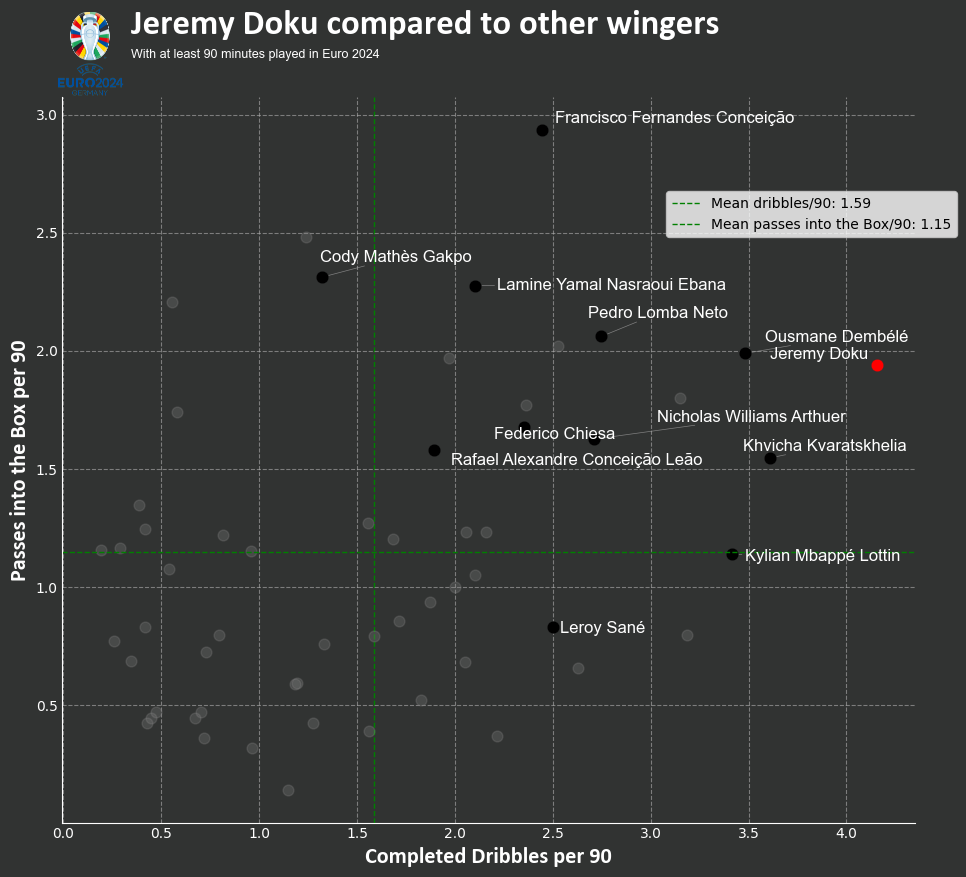

In [24]:
player = "Jeremy Doku"
background = "#313332"
title_font = "Calibri"
body_font = "Arial"
text_color = "w"
primary = "#e10600"

# Compute means
mean_xg = df_winger_stats_filtered["dribbles_per_90"].mean()
mean_danger_passes = df_winger_stats_filtered["passes_into_penalty_per_90"].mean()

# List of players to annotate (highlighted in color)
highlight_players = [
    "Lamine Yamal Nasraoui Ebana", 
    "Kylian Mbappé Lottin", 
    "Ousmane Dembélé", 
    "Khvicha Kvaratskhelia", 
    "Cody Mathès Gakpo", 
    "Nicholas Williams Arthuer", 
    "Pedro Lomba Neto",
    "Rafael Alexandre Conceição Leão",
    "Leroy Sané",
    'Francisco Fernandes Conceição',
    'Jeremy Doku',
    'Federico Chiesa'
]

from adjustText import adjust_text

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
fig.set_facecolor(background)
ax.set_facecolor(background)

texts = []  # store text objects for adjustText

for i, row in df_winger_stats_filtered.iterrows():
    if row["player_name"] in highlight_players:
        # Yamal = red dot, white name; others = black dot, black name
        if row["player_name"] == player:
            dot_color = "red"
            name_color = text_color
        else:
            dot_color = "black"
            name_color = text_color
        ax.scatter(row["dribbles_per_90"], row["passes_into_penalty_per_90"], color=dot_color, s=80, edgecolors=background, alpha=1, lw=.25, zorder=2)
        
        # Annotate only highlight players
        texts.append(
            ax.text(
                row["dribbles_per_90"],  
                row["passes_into_penalty_per_90"],
                row["player_name"],
                fontfamily=body_font,
                fontsize=12,
                color=name_color,
                zorder=3
            )
        )
    else:
        # Non-highlighted players = gray dots, no label
        ax.scatter(row["dribbles_per_90"], row["passes_into_penalty_per_90"], color="gray", s=60, alpha=0.3, zorder=2)

# Automatically adjust text positions to minimize overlap
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray", lw=0.5))

# Draw mean lines
ax.axvline(mean_xg, color="green", linestyle="--", linewidth=1, label=f"Mean dribbles/90: {mean_xg:.2f}", zorder=1)
ax.axhline(mean_danger_passes, color="green", linestyle="--", linewidth=1, label=f"Mean passes into the Box/90: {mean_danger_passes:.2f}")

ax.set_xlabel("Completed Dribbles per 90", fontfamily=title_font, fontweight="bold", fontsize=16, color=text_color)
ax.set_ylabel("Passes into the Box per 90", fontfamily=title_font, fontweight="bold", fontsize= 16, color=text_color)

ax.tick_params(axis="both",length=0, colors=text_color)


spines = ["top","right","bottom","left"]
for s in spines:
    if s in ["top","right"]:
        ax.spines[s].set_visible(False)
    else:
        ax.spines[s].set_color(text_color)

fig.text(
    0.43, 1.06, 
    "Jeremy Doku compared to other wingers", 
    color=text_color, fontsize=25, fontweight="bold", fontfamily=title_font, ha="center"
)
fig.text(
    0.26, 1.03, 
    "With at least 90 minutes played in Euro 2024", 
    color=text_color, fontsize=9, fontfamily=body_font, ha="center")

ax.grid(True, linestyle="--", alpha=0.6)
ax.legend(loc="upper left", bbox_to_anchor=(0.7, 0.88))

# Add badge/logo as a small inset
ax2 = fig.add_axes([0.02, 0.96, 0.15, 0.15])  # [left, bottom, width, height]
ax2.axis("off")  # turn off axes

# URL of the logo
url = "https://logos-world.net/wp-content/uploads/2021/10/UEFA-Euro-2024-Logo.png"

# Download and open the image
response = requests.get(url)
img = Image.open(BytesIO(response.content))

# Display the image
ax2.imshow(img)

# save and show
save_path = r"C:\Users\papad\OneDrive\Desktop\Study\MSc Data Science\25-26\HT25-1\Mathematical Modelling of Football\1. Event Data\Assignment\doku_compared.png"
fig.savefig(save_path, dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())

plt.tight_layout()
plt.show()


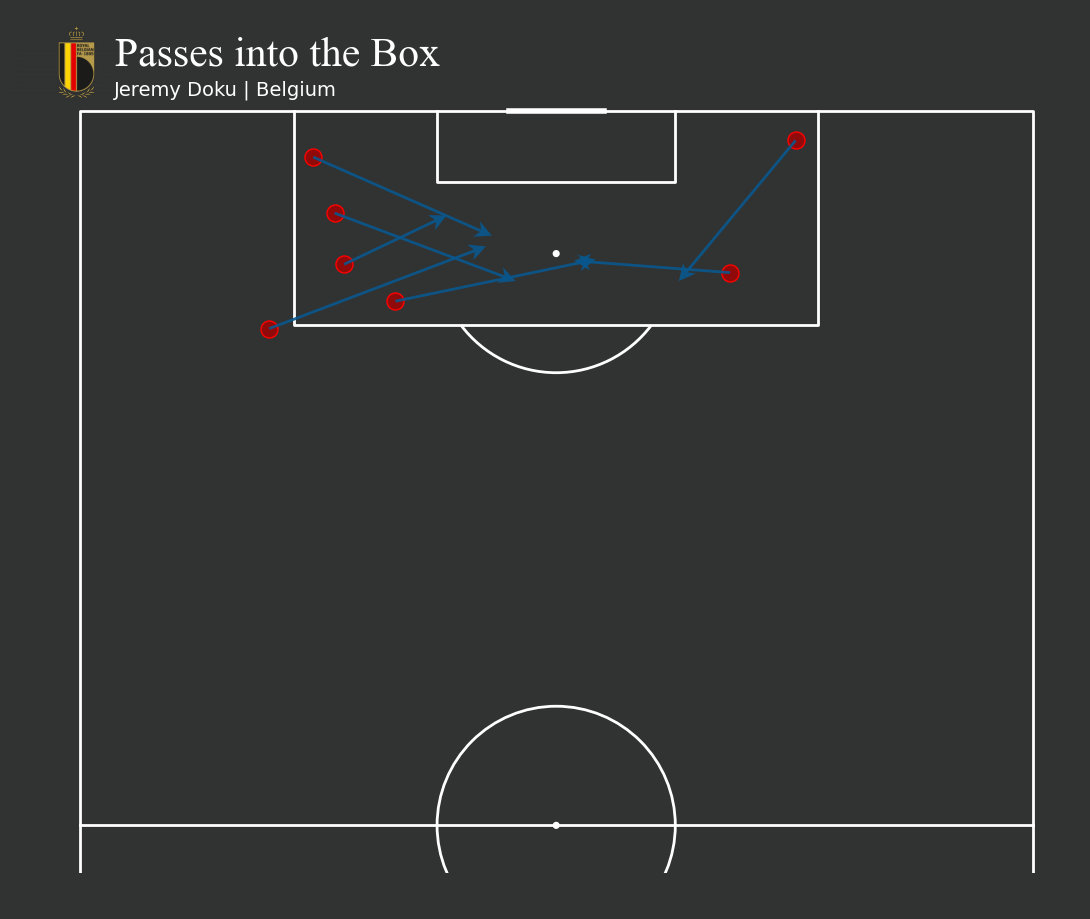

In [25]:
# create a new column with the display name you want
passes_into_penalty_doku["display_name"] = "Jeremy Doku"
fontname = "Times New Roman"
pitch_color = "#313332"
line_color = "white"

# vertical half-pitch
pitch = VerticalPitch(
    half=True,               # only half-pitch
    pitch_color=pitch_color,
    line_color=line_color
)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

fig.set_facecolor("#313332")

# scatter the location of passes into the box
pitch.scatter(
    passes_into_penalty_doku.x, passes_into_penalty_doku.y,
    s=150,
    color="#910A0AFF", edgecolors="red", linewidth=1, alpha=1,
    ax=ax["pitch"]
)

# add arrows for pass direction
pitch.arrows(
    passes_into_penalty_doku.x, passes_into_penalty_doku.y,
    passes_into_penalty_doku.end_x, passes_into_penalty_doku.end_y,
    ax=ax["pitch"],
    color="#09578E",
    alpha=0.9,
    width=2,
    headwidth=6,
    headlength=6
)

# add title
fig.text(
    0.1,
    0.97,
    'Passes into the Box',
    fontname=fontname,
    fontsize=30,
    ha='left',
    va='top',
    color=line_color
)

# subtitle
fig.text(
    0.2, 0.90,
    "Jeremy Doku | Belgium",
    ha="center", va="bottom",
    fontsize=14, color=line_color
)

# Belgium logo
ax2 = fig.add_axes([0.005, 0.88, 0.12, 0.12])
ax2.axis("off")
url = "https://logos-world.net/wp-content/uploads/2024/06/Belgium-National-Football-Team-Logo-500x281.png"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)

# save and show
save_path = r"C:\Users\papad\OneDrive\Desktop\Study\MSc Data Science\25-26\HT25-1\Mathematical Modelling of Football\1. Event Data\Assignment\Doku_PassesIntoBox_Euro2024.png"
fig.savefig(save_path, dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.tight_layout()
plt.show()


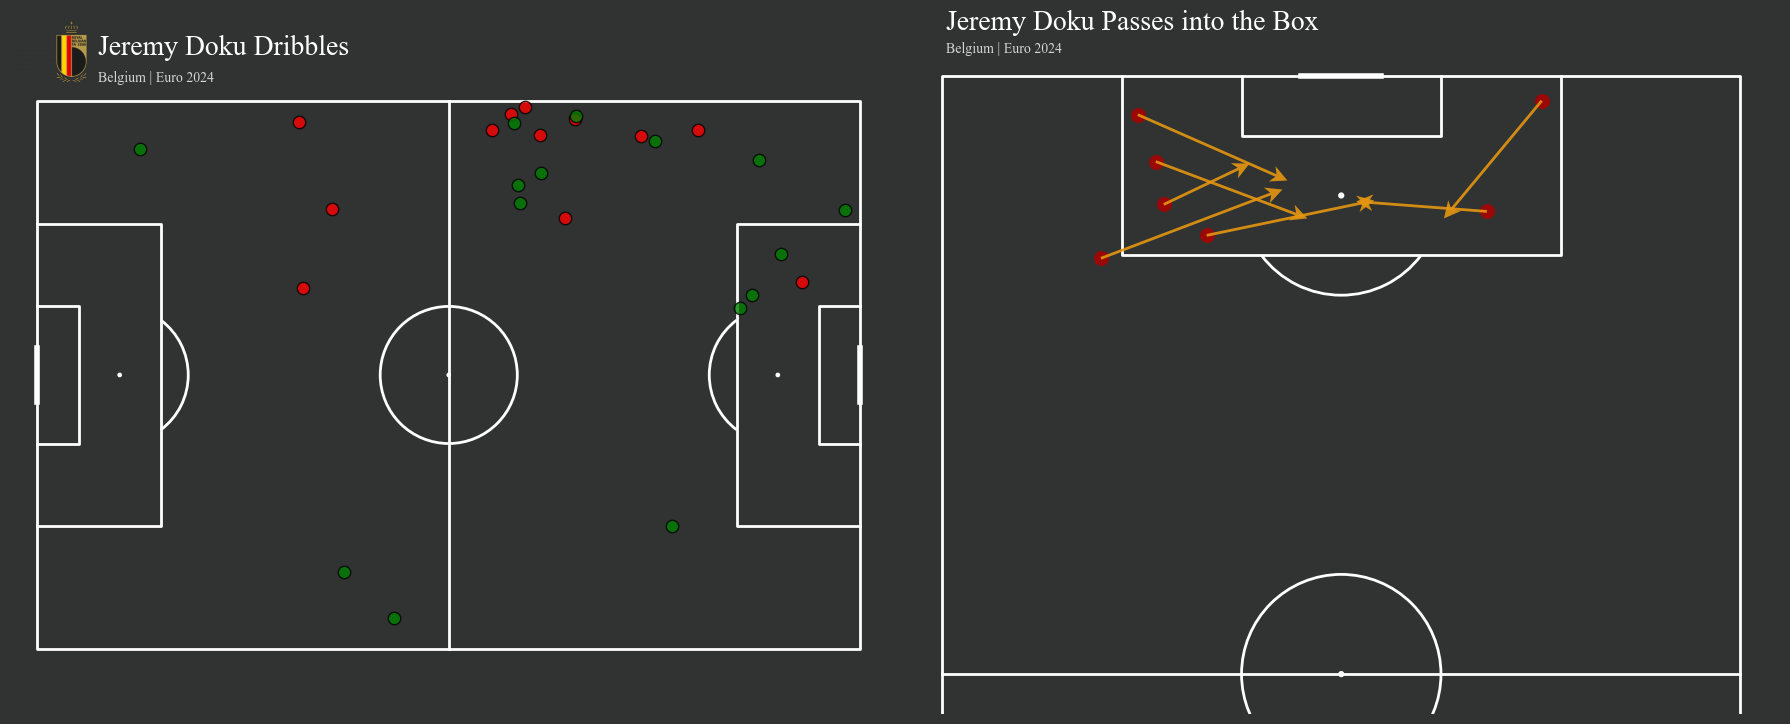

In [35]:
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# Set general style
fontname = "Times New Roman"
pitch_color = "#313332"
line_color = "white"

# Create figure with 2 subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(18, 9))
fig.set_facecolor(pitch_color)

# ------------------ Plot 1: Dribbles ------------------
pitch_left = Pitch(pitch_color=pitch_color, line_color=line_color)
pitch_left.draw(ax=axes[0])

# Incomplete dribbles first (bottom)
pitch_left.scatter(
    dribbles_doku.loc[dribbles_doku["outcome_name"] == "Incomplete", "x"],
    dribbles_doku.loc[dribbles_doku["outcome_name"] == "Incomplete", "y"],
    s=80, color="red", edgecolors="black", linewidth=1,
    alpha=0.8, ax=axes[0], zorder=1
)

# Complete dribbles second (on top)
pitch_left.scatter(
    dribbles_doku.loc[dribbles_doku["outcome_name"] == "Complete", "x"],
    dribbles_doku.loc[dribbles_doku["outcome_name"] == "Complete", "y"],
    s=80, color="green", edgecolors="black", linewidth=1,
    alpha=0.8, ax=axes[0], zorder=2
)

# Main title
axes[0].text(
    0.1, 1.02,
    "Jeremy Doku Dribbles",
    transform=axes[0].transAxes,
    ha="left", va="bottom",
    fontsize=20, color="white", fontname=fontname
)

# Subtext (Euro 2024)
axes[0].text(
    0.1, 0.98,
    "Belgium | Euro 2024",
    transform=axes[0].transAxes,
    ha="left", va="bottom",
    fontsize=10, color="white", fontname=fontname, alpha=0.8
)


# ------------------ Plot 2: Passes into Box ------------------
pitch_right = VerticalPitch(half=True, pitch_color=pitch_color, line_color=line_color)
pitch_right.draw(ax=axes[1])

# scatter passes into box
pitch_right.scatter(
    passes_into_penalty_doku.x, passes_into_penalty_doku.y,
    s=100,
    color="#9A0808", edgecolors="#9A0808", linewidth=0.8, alpha=1,
    ax=axes[1]
)
# add arrows
pitch_right.arrows(
    passes_into_penalty_doku.x, passes_into_penalty_doku.y,
    passes_into_penalty_doku.end_x, passes_into_penalty_doku.end_y,
    ax=axes[1],
    color="#E59711",
    alpha=0.9,
    width=2,
    headwidth=6,
    headlength=6
)
# Main title (left-aligned)
axes[1].text(
    0.05, 1,
    "Jeremy Doku Passes into the Box",
    transform=axes[1].transAxes,
    ha="left", va="bottom",
    fontsize=20, color="white", fontname=fontname
)

# Subtitle
axes[1].text(
    0.05, 0.97,
    "Belgium | Euro 2024",
    transform=axes[1].transAxes,
    ha="left", va="bottom",
    fontsize=10, color="white", fontname=fontname, alpha=0.8
)



# ------------------ Add Belgium logo ------------------
# Load the same logo twice (or use two different logo URLs if you want)
logo_url = "https://logos-world.net/wp-content/uploads/2024/06/Belgium-National-Football-Team-Logo-500x281.png"
response = requests.get(logo_url)
img = Image.open(BytesIO(response.content))

# --- Add first logo (top-left) ---
logo_ax1 = fig.add_axes([0.007, 0.823, 0.07, 0.07])  # [left, bottom, width, height] in figure coords
logo_ax1.axis("off")
logo_ax1.imshow(img)

# --- Add second logo (top-center) ---
# logo_ax2 = fig.add_axes([0.54, 0.85, 0.08, 0.08])   # adjust position
# logo_ax2.axis("off")
# logo_ax2.imshow(img)

# ------------------ Save and show ------------------
save_path = r"C:\Users\papad\OneDrive\Desktop\Study\MSc Data Science\25-26\HT25-1\Mathematical Modelling of Football\1. Event Data\Assignment\Doku_Dribbles_PassesBox_Euro2024.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())
plt.tight_layout()
plt.show()
